
# <b><span style='color:#2B0245'>Importing necessary libraries and Load dataset</span></b>


In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#nlp libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
#load dataset


data = pd.read_csv('/kaggle/input/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv')
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
data.shape

(17880, 18)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [25]:
del data['title']
del data['location']
del data['department']
del data['company_profile']
del data['description']
del data['requirements']
del data['benefits']
del data['employment_type']
del data['required_experience']
del data['required_education']
del data['industry']
del data['function']
del data['job_id']
del data['salary_range']
del data['telecommuting']
del data['has_company_logo']
del data['has_questions']


# <b><span style='color:#2B0245'>Data Cleaning and Visualizations</span></b>




In [5]:
#check number of null values

data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
data= data.replace(np.nan, '', regex=True)

In [7]:
#combine data

data['text'] = data['title'] + ' ' + data['location'] + ' ' + data['department'] + ' ' + data['company_profile'] + ' ' + data['description'] + ' ' + data['requirements'] + ' ' + data['benefits'] + ' ' + data['employment_type'] + ' ' + data['required_education'] + ' ' + data['industry'] + ' ' + data['function']

In [8]:
fraudjob = data[data.fraudulent==1].text
actualjob = data[data.fraudulent==0].text

# **Data Pre-processing**

In [9]:
# list of punctuation marks
punctuations = string.punctuation

# Create list of stopwords
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    
    mytokens = parser(sentence)

    # Lemmatizing and convert to lower case
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens


In [10]:
#custom transformer

from sklearn.base import TransformerMixin


class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [11]:
#bag of words

bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3),lowercase=True)
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x75a8d24134d0>)


# <b><span style='color:#2B0245'>Data Split,Model building and Evaluation</span></b>





In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.25, random_state=101)

In [13]:
clf = RandomForestClassifier()
# Create pipeline 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])
# fit model
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x75a84e516110>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x75a8d24134d0>)),
                ('classifier', RandomForestClassifier())])

In [14]:

# Predicting with test data
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9841163310961969
Random Forest Recall: 0.6568627450980392


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4266
           1       0.99      0.66      0.79       204

    accuracy                           0.98      4470
   macro avg       0.99      0.83      0.89      4470
weighted avg       0.98      0.98      0.98      4470



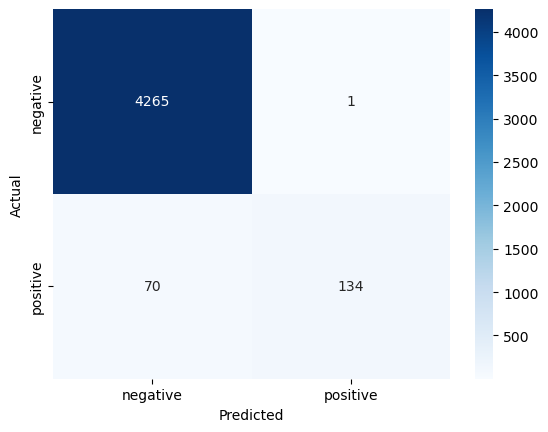

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate classification report
print(classification_report(y_test, predicted))

# Generate confusion matrix
cm = confusion_matrix(y_test, predicted)

# Create heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
predicted = pipe.predict(X_test)

# Calculate model metrics
accuracy = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)

results = pd.DataFrame({'Actual Outcome': y_test, 'Predicted Outcome': predicted})

# Display dataframe
print(results)


       Actual Outcome  Predicted Outcome
15491               0                  0
3688                0                  0
12896               0                  0
15557               0                  0
11898               0                  0
...               ...                ...
4309                0                  0
8683                1                  1
14401               0                  0
4769                0                  0
1985                0                  0

[4470 rows x 2 columns]


In [17]:
clf=MultinomialNB()
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x75a8395ce110>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x75a8d24134d0>)),
                ('classifier', MultinomialNB())])

In [18]:
predicted = pipe.predict(X_test)
print("Navie bayes Accuracy:", accuracy_score(y_test, predicted))
print("Navie bayes Recall:", recall_score(y_test, predicted))

Navie bayes Accuracy: 0.9782997762863535
Navie bayes Recall: 0.5294117647058824


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4266
           1       0.99      0.53      0.69       204

    accuracy                           0.98      4470
   macro avg       0.98      0.76      0.84      4470
weighted avg       0.98      0.98      0.98      4470



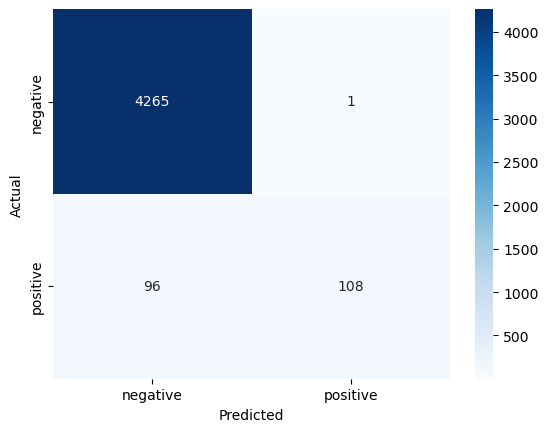

In [19]:
print(classification_report(y_test, predicted))

cm = confusion_matrix(y_test, predicted)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
predicted = pipe.predict(X_test)

# Calculate model metrics
accuracy = accuracy_score(y_test, predicted)
recall = recall_score(y_test, predicted)

results = pd.DataFrame({'Actual Outcome': y_test, 'Predicted Outcome': predicted})

# Display dataframe
print(results)

       Actual Outcome  Predicted Outcome
15491               0                  0
3688                0                  0
12896               0                  0
15557               0                  0
11898               0                  0
...               ...                ...
4309                0                  0
8683                1                  1
14401               0                  0
4769                0                  0
1985                0                  0

[4470 rows x 2 columns]
